In [ ]:
# MIXED MM -> Latent Profile Analysis COVARIATES

In [13]:
## Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, ParameterGrid
from stepmix.bootstrap import blrt_sweep
from stepmix.stepmix import StepMix
from stepmix.utils import get_mixed_descriptor

In [14]:
# Load data 

# MEASUREMENT MODEL

# CONTINUOUS + BINARY MM
cnt = pd.read_csv('../data/Xcnt_std.csv', index_col=0)

# Define MIXED descriptor for MM
# (unspecified variables are simply not included in mixed_data)
X_mixed, mixed_descriptor = get_mixed_descriptor(
    dataframe = cnt,
    continuous = ['rel_cnt', 'rel_clo'], # can also deal with continuous NaN!!
    binary_nan = ['tra_lca', 'cnf_lca', 'sup_lca', 'mon_lca']
)

In [15]:
# Load data 

# STRUCTURAL MODEL
Z = pd.read_csv('../data/Z.csv', index_col = 0)

# The covariate model as an internal optimization procedure
# We can specify additional arguments such as the learning rate
# and the optimization method
opt_params = {
    'method': 'newton-raphson',  # Can also be "gradient",
    'intercept': True,
    'max_iter': 1,  # Number of opt. step each time we update the covariate model
}

In [16]:
# Set ups
k = 5  # number of classes
m = 3000 # maximum number iterations
r = 5 # number of times to estimate models (nrep > 1 automates search for global max)

# random seed
seed = 240792

In [17]:
# Define base model for MIXED with covariates (2-step)
mixed_cov2 = StepMix(
    n_components = 5, 
    n_steps = 2,
    measurement = mixed_descriptor,   
    structural = 'covariate',
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_cov2.fit(X_mixed, Z)

Fitting StepMix...


Initializations (n_init) :  20%|███▌              | 1/5 [00:08<00:35,  8.79s/it, max_LL=8.38e+4, max_avg_LL=1.32]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:35: SyntaxWarning: invalid escape sequence '\_'
  """StepMix estimator for Latent Class Analysis.


KeyboardInterrupt: 

In [ ]:
# Define base model for MIXED with covariates (3-step, ML)
mixed_cov3ml = StepMix(
    n_components = 5, 
    n_steps = 3,
    correction = 'ML',
    measurement = mixed_descriptor,    
    structural = 'covariate',
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_cov3ml.fit(X_mixed, Z)

In [45]:
# WHICH CORRECTION -- MIXED 

# Loop over number of classes (3-step ML)
result_mixed_corr = dict(step=[], correction=[], log_likelihood=[], caic=[], abic=[], relative_entropy=[])

for c in [None, 'BCH', 'ML']:
    for s in [2, 3]:
        # Create a new StepMix instance for each s & c
        mixed_cov5 = StepMix(
            n_components=5, 
            n_steps=s, # loop over steps
            correction=c, # and loop over corrections
            measurement=mixed_descriptor,   
            structural='covariate',
            verbose=0, 
            n_init=r,
            max_iter=m,
            random_state=seed
        )
        
        # Fit the model
        mixed_cov5.fit(X_mixed, Z)
        
        # Get log-likelihood
        ll = mixed_cov5.score(X_mixed, Z)
    
        # Get cAIC
        caic = mixed_cov5.caic(X_mixed, Z)
    
        # Get sBIC
        abic = mixed_cov5.sabic(X_mixed, Z)
    
        # Get relative entropy
        rel_entr = mixed_cov5.relative_entropy(X_mixed, Z)
        
        # Store results
        result_mixed_corr['step'].append(s)
        result_mixed_corr['correction'].append(c)
        result_mixed_corr['log_likelihood'].append(ll)
        result_mixed_corr['caic'].append(caic)
        result_mixed_corr['abic'].append(abic)
        result_mixed_corr['relative_entropy'].append(rel_entr)

Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:24<00:00,  4.88s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:04<00:00,  1.06it/s, max_LL=1.58e+5, max_avg_LL=2.48]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:28<00:00,  5.64s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:26<00:00,  5.21s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:04<00:00,  1.18it/s, max_LL=1.58e+5, max_avg_LL=2.48]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:24<00:00,  4.99s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:26<00:00,  5.26s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:07<00:00,  1.43s/it, max_LL=1.58e+5, max_avg_LL=2.48]


Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:26<00:00,  5.25s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:03<00:00,  1.35it/s, max_LL=-8.77e+4, max_avg_LL=-1.38]


In [46]:
result_mixed_corr = pd.DataFrame(result_mixed_corr)
result_mixed_corr

,step,correction,log_likelihood,caic,abic,relative_entropy
0,2,None,2.478562,-314086.078561,-313204.993407,0.999595
1,3,None,2.444854,-309793.592277,-308912.507123,0.999576
2,2,BCH,2.478562,-314086.078561,-313204.993407,0.999595
3,3,BCH,2.444421,-309738.451418,-308857.366264,0.999566
4,2,ML,2.478562,-314086.078561,-313204.993407,0.999595
5,3,ML,2.478562,-314086.067067,-313204.981914,0.999596


Text(0.5, 1.0, 'Log-likelihood across steps & corrections\nMixed model, continuous vars standardized\n5 classes')

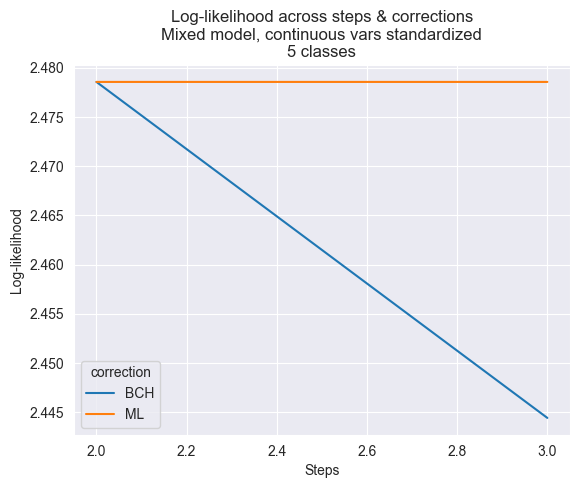

In [47]:
# Higher is better
sns.set_style("darkgrid")
sns.lineplot(data = result_mixed_corr, 
             x = 'step', 
             y = 'log_likelihood',
             hue = 'correction')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood across steps & corrections\n' 
          'Mixed model, continuous vars standardized\n'
         '5 classes')